# Model creation (superresolution)

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [45]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import tools.common_functions as cf
import tools.regression as reg

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
NR_SUBREGIONS = 1
DATA_NORMAL_FORCE_FILE = f"table_calibration/2x2_taxel_calibration_with_silicon"

# Automated
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)] + ['level_sensor']


In [46]:
# Load in data file and prepare for fitting
normal_force_df = cf.prepare_data_for_fitting(DATA_NORMAL_FORCE_FILE, ARRAY_SIZE, SENSOR_LAG, False)
normal_force_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112519 entries, 0 to 112518
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   t_wall        112519 non-null  float64
 1   level_sensor  112519 non-null  int64  
 2   X0            112519 non-null  float64
 3   Y0            112519 non-null  float64
 4   Z0            112519 non-null  float64
 5   X1            112519 non-null  float64
 6   Y1            112519 non-null  float64
 7   Z1            112519 non-null  float64
 8   X2            112519 non-null  float64
 9   Y2            112519 non-null  float64
 10  Z2            112519 non-null  float64
 11  X3            112519 non-null  float64
 12  Y3            112519 non-null  float64
 13  Z3            112519 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 12.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 627913 entries, 1 to 627913
Data columns (total 25 columns):
 #   Column        Non

In [ ]:
# Extract boundary points
center_points, normal_force_normalized_df = cf.extract_center_points_from_data(normal_force_df, ARRAY_SIZE_SUB, normalize=True) 

plt.scatter(normal_force_normalized_df['X'], normal_force_normalized_df['Y'],s=1, c='r')
plt.scatter(center_points[:,0], center_points[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# Now split into the 4 regions used for fitting
regions_data = cf.split_data_into_regions(normal_force_df, center_points, min_distance=0.1)

for data in regions_data:
  print(data.head())
  plt.scatter(data['X'], data['Y'],s=1)
plt.show()

In [ ]:
# Now fit the data per region (=taxel)
# Model: {X{i}, Y{i}, Z{i}} -> F_z{i}

normal_force_models_taxels = []

for region in regions_data:
  
  # Find largest activation 
  Z_measurements = region[[f'Z{i}' for i in range(ARRAY_SIZE)]]
  largest_activation_in_region_index = np.argmax(np.max(Z_measurements) - np.min(Z_measurements))
  
  print("Taxel {} has largest activation".format(largest_activation_in_region_index))
  
  X = region[[f'Z{largest_activation_in_region_index}']]
  y = region[['F_z']]
  
  # Fit
  model = reg.create_regression_pipeline_and_fit(X, y)
  model.activation_index = largest_activation_in_region_index
  
  normal_force_models_taxels.append(model)
  

In [ ]:
errors = []
indices = []

for model, region in zip(normal_force_models_taxels, regions_data):
  
  print(model.activation_index)
  indices.append(model.activation_index)
  
  # Predict
  Z_measurements = region[[f'Z{i}' for i in range(ARRAY_SIZE)]]
  X = region[[f'Z{model.activation_index}']]
  Y_pred = model.predict(X)
  
  print(Y_pred.shape)
  
  plt.plot(region[[f'Z{model.activation_index}']])
  plt.show()
  
  # Plot against actual
  for i, name in enumerate(['F_z']):
    plt.figure()
    plt.title(name)
    plt.plot(region[name])
    plt.plot(Y_pred)
    plt.show()
    
  # Calculate error
  errors.append(region[name].to_numpy() - Y_pred[:, 0])

  plt.show()
  
i = 0
for index, err in zip(indices, errors):
  
  plt.plot(regions_data[i][f'F_z'], err)
  i += 1

# Hysteresis testing


In [48]:
split_df = normal_force_df[normal_force_df['level_sensor'] == -3]

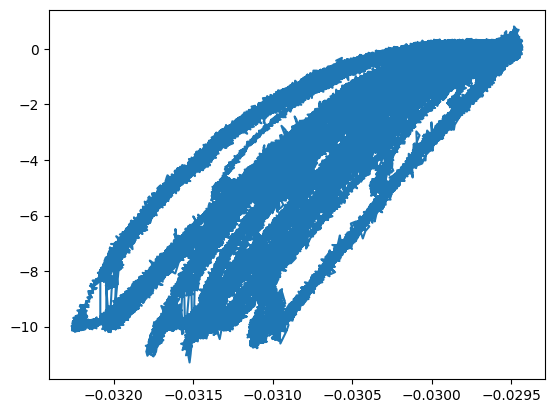

In [50]:
plt.plot(split_df['Z'], split_df['F_z'])

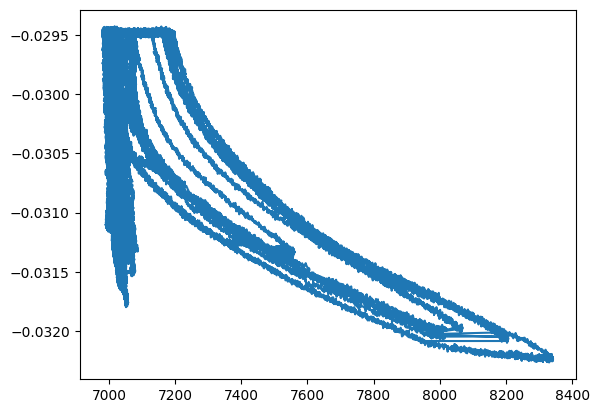

In [51]:
plt.plot(split_df['Z2'], split_df['Z'])

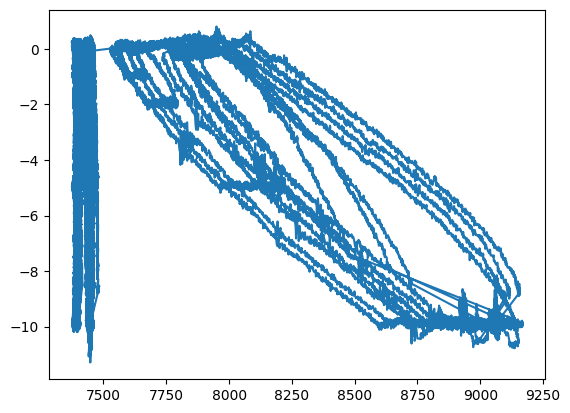

In [53]:
plt.plot(split_df['Z0'], split_df['F_z'])

In [ ]:
# Plot F_z vs normalized deformation
min_index = 600
max_index = 3200
data = regions_data[0].copy()[min_index:max_index]

z_data = data['Z'].to_numpy()
z_data -= z_data[0]
# if np.min(z_data) < 0:
z_data *= -1

measurements = data['Z2'].to_numpy()
output = data['F_z'].to_numpy()

def moving_average(x, w):
    return np.pad(np.convolve(x, np.ones(w), 'valid') / w, (w, 0), mode='constant')
  
differential = np.diff(moving_average(measurements, 10))
c = ['r' if d < 0 else 'g' for d in differential]

mask = differential > 0

fig, axs = plt.subplots(2)

axs[0].plot(z_data)
# plt.ylabel('Deformation')
# plt.show()

axs[1].plot(np.diff(moving_average(np.diff(moving_average(z_data, 10)), 10)))
# plt.ylabel('Deformation')
plt.show()

plt.plot(data['F_z'].to_numpy())
plt.ylabel('Force')
plt.show()
plt.plot(data['F_z'].to_numpy() / data['Z2'].to_numpy())
plt.ylabel('Measurement')
plt.show()
plt.plot(z_data, data['F_z'])
plt.xlabel('Deformation')
plt.ylabel('Force')
plt.show()

plt.plot(differential)
plt.show()

plt.scatter(range(len(measurements)), measurements, c=c, s=1)
plt.ylabel('Measurement (Z2)')
# plt.ylabel('Force')
plt.show()

plt.scatter(range(len(output)), output,  c=c, s=1)
plt.ylabel('Force')
plt.show()

In [ ]:
def calculate_corrected_data(params):

  a, b, c, d = params

  pos_weights = np.linspace(a, b, len(measurements))
  neg_weights = np.linspace(c, d, len(measurements))

  corrected_measurements = np.zeros(len(measurements))

  for i in range(1, len(measurements)):
    if mask[i]:
      corrected_measurements[i] = corrected_measurements[i - 1] + differential[i] * pos_weights[i]
    else:
      corrected_measurements[i] = corrected_measurements[i - 1] + differential[i] * neg_weights[i]
      
  return corrected_measurements

In [ ]:
a = np.linspace(13, 14.5, 10)
b = np.linspace(4, 6, 10)
c = np.linspace(17, 20, 10)
d = np.linspace(20, 100, 10)

MSEs = []
best_params = []
best_MSE = 999999999

for i in range(len(a)):
  for j in range(len(b)):
    for k in range(len(c)):
      for l in range(len(d)):
        corrected_measurements = calculate_corrected_data([a[i], b[j], c[k], d[l]])
        
        MSE = np.mean((corrected_measurements - output) ** 2)
        MSEs.append(MSE)
        
        if MSE < best_MSE:
          best_params = [a[i], b[j], c[k], d[l]]
          best_MSE = MSE
          
      else:
        continue
      break
    else:
      continue
    break
  else:
    continue
  break

In [ ]:
print(best_params)
plt.plot(MSEs)
plt.show()

corrected_measurements = calculate_corrected_data(best_params)
plt.plot(output)
plt.plot(corrected_measurements)

In [ ]:
class Hysteron:
  
  def __init__(self, alpha, beta): # beta > alpha
    self.alpha = alpha
    self.beta = beta
    self.state = 0
    
  def update(self, measurement):
    
    if measurement > self.beta:
      self.state = 1
    elif measurement < self.alpha:
      self.state = 0
    
    return self.state
    

In [ ]:
# Make hysterons with beta - alpha = step from 0 to 1 
step = 0.01

hysterons = []
for alpha in np.linspace(0, 1 - step, int(1/step)):
  for beta in np.linspace(alpha + step, 1, int(1/step)):
    hysterons.append(Hysteron(alpha, beta))

# Now plot the 

weights = np.linspace(0.9, 1.1, len(hysterons))
weights /= np.sum(weights)

X = np.sin(np.linspace(0, np.pi, 100))
y = np.zeros(100)

c = ['b' for i in range(50)] + ['r' for i in range(50)]

for i in range(len(X)):
  tmp = 0
  for j, hys in enumerate(hysterons):
    tmp += hys.update(X[i]) * weights[j]
    
  y[i] = tmp
  
plt.scatter(X, y, s=1,c=c)
  

In [ ]:
import hysteresis as hys

xy = np.column_stack([data['Z2'], data['F_z']])

myHys = hys.Hysteresis(xy)
myHys.plot(showReversals = True)

In [ ]:
dataset = regions_data[0][['Z2', 'F_z']][min_index:max_index].copy()

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

print(train.shape, test.shape)

plt.plot(train['Z2'], train['F_z'])
plt.plot(test['Z2'], test['F_z'])

In [ ]:
# Split the data
def create_dataset(dataset, nr_steps):
    dataX, dataY = [], []
    for i in range(dataset.shape[0] - nr_steps - 1):
        a = dataset[i:(i + nr_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + nr_steps, 1])
    return np.array(dataX), np.array(dataY)

n_steps = 50
features = 1

# split into samples
X_train, y_train = create_dataset(train.to_numpy(), n_steps)
X_test, y_test = create_dataset(test.to_numpy(), n_steps)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Building an RNN

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

# Define LSTM model
model = Sequential()
# model.add(LSTM(64, return_sequences=True))  
model.add(LSTM(16))  
model.add(Dense(1, activation='relu'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer=Adam(0.01), loss=MeanSquaredError(), metrics=['accuracy'])


# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16)

In [ ]:

# make predictions
trainPredict = model.predict(np.linspace(0, 0.6, 100).reshape(-1, 1, 1))
testPredict = model.predict(X_test)

print(trainPredict.shape)
print(testPredict.shape)

print(y_train.shape)
print(y_test.shape)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps:len(trainPredict)+n_steps, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(n_steps*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset['Z2'], dataset['F_z'])
plt.plot(dataset['Z2'],trainPredictPlot)
plt.plot(dataset['Z2'],testPredictPlot)
# plt.plot(testPredictPlot)
plt.show()

plt.plot(dataset['F_z'])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

# Validation

In [ ]:
# Validate against the subsampled version
# Load in data file and prepare for val
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)
normal_force_df_val.info()

In [ ]:
combined_model = reg.CombinedModel([normal_force_models_taxels[i] for i in [3, 2, 0, 1]])

In [ ]:
# Predict F_z{i} based on measurements
X = normal_force_df_val[[f'Z{i}' for i in range(ARRAY_SIZE)]].to_numpy()
F_zi = combined_model.predict(X)
for i in range(4):
  plt.plot(normal_force_df_val[f'F_z'])
  plt.plot(F_zi[:, i])
  plt.show()

In [ ]:
# Try to add them all up
plt.plot(normal_force_df_val['F_z'])
plt.plot(np.sum(F_zi, axis=1))


In [ ]:
# Check the distribution of all touch points F_z values
F_z_pred = np.sum(F_zi, axis=1)
F_z_virt = []

print(F_zi.shape)
print(F_z_pred.shape)

for i in range(ARRAY_SIZE):
  F_z_virt.append(F_zi[:, i] / F_z_pred)
  
for v in F_z_virt:
  print(v.shape)
  plt.plot(v[3000:])
  # plt.ylim(0, 1)
  plt.show()


In [ ]:
# Create a model that predicts the virtual taxels based on multi-taxel force models
